In [1]:
import spacy
from spacy.lang.fr.stop_words import STOP_WORDS
from nltk.corpus import stopwords
import pandas as pd
import os

In [2]:
df = pd.read_csv(r"C:\Users\antoa\Desktop\projet certif\RGBD\table_produits\produits.csv")

In [3]:
df = df.dropna(subset=['saveur'])

In [4]:
# Charger le modèle spaCy pour le français
nlp = spacy.load("fr_core_news_sm")

c:\Users\antoa\anaconda3\envs\nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def clean_text_french(text, custom_stopwords):
    """
    Nettoyer un texte en français :
    - Supprimer les stopwords et les symboles inutiles.
    - Appliquer la lemmatisation.
    - Utiliser des stopwords personnalisés.
    """
    doc = nlp(text)
    clean_words = [
        token.lemma_.lower()  # Appliquer la lemmatisation et mettre en minuscule
        for token in doc
        if token.is_alpha and token.text.lower() not in custom_stopwords  # Supprimer les mots inutiles
    ]
    return ' '.join(clean_words)

In [7]:
# Nouveau chemin du fichier french.txt
french_stopwords_path = r'C:\Users\antoa\Desktop\projet certif\app\models\french.txt'

# Vérifier si le fichier existe et le lire
if os.path.exists(french_stopwords_path):
    with open(french_stopwords_path, 'r', encoding='utf-8') as file:
        french_stopwords = file.read().splitlines()  # Lire chaque ligne comme un mot séparé
    print(french_stopwords[:10])  # Afficher les 10 premiers mots vides pour vérifier
else:
    print(f"Le fichier french.txt est introuvable dans {french_stopwords_path}")


['a', 'ai', 'aie', 'aient', 'aies', 'ait', 'alors', 'as', 'au', 'aucun']


In [8]:
# Nettoyer les descriptions en utilisant les stopwords personnalisés
df['description_cleaned'] = df['description'].apply(lambda x: clean_text_french(x, french_stopwords))


In [9]:
df['nom_produit_cleaned'] = df['nom_produit'].apply(lambda x: clean_text_french(x, french_stopwords))


In [10]:
# Afficher les descriptions originales et nettoyées
for original, cleaned in zip(df['description'].head(5), df['description_cleaned'].head(5)):
    print(f"Original: {original}")
    print(f"Nettoyé: {cleaned}")
    print("-" * 50)

Original: Le e-liquide Ragnarok par A&L Ultimate est un produitprêt à l'emploipour cigarette électronique. Dans sa fiole 10ml, vous retrouverez des saveurs de fruits rouges, accompagnées d'un goût frais de cassis. Idéal pour débuter, ce e-liquide vous est proposé en différents taux de nicotine au choix : 0, 3, 6, ou 12mg/ml. Qu'est-ce que le Ragnarok Ultimate ? Le Ragnarok, c'est unerecette fraiche aux goûts de fruitsdehaute qualité française, signée Arômes et Liquides (A&L). Ici, vous en profiterez dans sa version e-liquide prêt à vaper. Conforme à la loi TPD, le e liquide Ragnarok est présenté en fiole PET de 10ml. Pourquoi ? Afin de vous assurer unproduit déjà nicotiné à votre convenance! Pourquoi choisir le Ragnarok en e-liquide 10ml ? Simple, pratique et efficace, le e-liquide Ragnarok en 10ml permet de démarrer sans attendre votre séance de vapotage. Déjà minutieusement travaillé, dosé et nicotiné, il vous suffit de le verser dans votre réservoir de cigarette électronique pour l'

In [11]:
# Combiner description_cleaned et saveur en une seule colonne pour l'embedding
df['combined_text'] = df['description_cleaned'] + " " + df['nom_produit_cleaned'].str.replace(",", " ")

In [12]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialiser le vectoriseur TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words=french_stopwords)

# Appliquer TF-IDF sur les descriptions nettoyées
X_tfidf = tfidf_vectorizer.fit_transform(df['description_cleaned'])

# Vérifier la taille des vecteurs générés
print(f"Taille des vecteurs TF-IDF : {X_tfidf.shape}")

Taille des vecteurs TF-IDF : (1528, 4222)


In [16]:
# Transformer les labels multiples en une matrice binaire (0 ou 1 pour chaque saveur)
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['saveur'].apply(lambda x: x.split(', ')))

# Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [17]:
# Entraîner un classificateur RandomForest avec MultiOutputClassifier pour la classification multi-label
clf = RandomForestClassifier(n_estimators=100, random_state=42)
multi_target_clf = MultiOutputClassifier(clf, n_jobs=-1)

# Entraîner le modèle
multi_target_clf.fit(X_train, y_train)

# Évaluer le modèle
y_pred = multi_target_clf.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

                     precision    recall  f1-score   support

            abricot       0.00      0.00      0.00         3
            agrumes       0.00      0.00      0.00         1
             amande       1.00      0.50      0.67         4
             ananas       0.33      0.08      0.12        13
               anis       1.00      0.93      0.96        40
               baie       0.91      0.48      0.62        21
         baie noire       0.00      0.00      0.00         0
              baies       0.90      0.43      0.58        21
       baies noires       0.00      0.00      0.00         1
       baies rouges       1.00      0.07      0.13        14
             banane       0.00      0.00      0.00         4
       barbe à papa       0.00      0.00      0.00        10
            beignet       0.00      0.00      0.00         0
beurre de cacahuète       0.00      0.00      0.00         0
            biscuit       1.00      0.40      0.57        10
             bonbon    

c:\Users\antoa\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\antoa\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\antoa\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [18]:
# Calculer l'accuracy globale (Subset Accuracy)
subset_accuracy = accuracy_score(y_test, y_pred)
print(f"Subset Accuracy: {subset_accuracy:.4f}")

# Calculer l'accuracy pour chaque étiquette
for label, accuracy in zip(mlb.classes_, (y_pred == y_test).mean(axis=0)):
    print(f"Accuracy for label '{label}': {accuracy:.4f}")

# Afficher un rapport de classification (précision, rappel, f1-score pour chaque label)
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=mlb.classes_))

Subset Accuracy: 0.1928
Accuracy for label 'abricot': 0.9902
Accuracy for label 'agrumes': 0.9967
Accuracy for label 'amande': 0.9935
Accuracy for label 'ananas': 0.9542
Accuracy for label 'anis': 0.9902
Accuracy for label 'baie': 0.9608
Accuracy for label 'baie noire': 1.0000
Accuracy for label 'baies': 0.9575
Accuracy for label 'baies noires': 0.9967
Accuracy for label 'baies rouges': 0.9575
Accuracy for label 'banane': 0.9869
Accuracy for label 'barbe à papa': 0.9673
Accuracy for label 'beignet': 1.0000
Accuracy for label 'beurre de cacahuète': 1.0000
Accuracy for label 'biscuit': 0.9804
Accuracy for label 'bonbon': 0.9706
Accuracy for label 'bonbons': 0.9575
Accuracy for label 'bubble gum': 0.9869
Accuracy for label 'bubblegum': 0.9869
Accuracy for label 'cacahuète': 0.9967
Accuracy for label 'cactus': 0.9935
Accuracy for label 'café': 0.9869
Accuracy for label 'cannelle': 0.9935
Accuracy for label 'cappuccino': 1.0000
Accuracy for label 'caramel': 0.9379
Accuracy for label 'carame

c:\Users\antoa\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\antoa\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\antoa\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


It seems like the model is providing high accuracy for some labels, but others are performing poorly, especially those with fewer samples. Here are a few things you can do to improve the model:

Class Imbalance: Some classes are represented by very few samples (like 'abricot', 'baie noire', etc.). This leads to poor performance for those classes, as the model struggles to generalize with limited data. You could try balancing the dataset by:

Using techniques like oversampling or undersampling to ensure more equal representation of each class.
Data augmentation to artificially increase the size of underrepresented classes.
Evaluation Metrics: The classification report shows low precision and recall for many of the classes, which could be indicative of overfitting to the more frequent classes. You might want to experiment with different strategies, like:

F1-score: For handling imbalanced classes, F1-score can be more informative than accuracy. You can prioritize improving the F1-score for underperforming classes.
Weighted metrics: Consider using weighted averages for precision, recall, and F1-score to give more importance to less frequent classes.
Model Tuning: Since some labels are highly accurate and others aren't, it may be helpful to tune the model further:

Try adjusting hyperparameters like learning rate, dropout, batch size, or even the choice of model.
Experiment with different architectures, such as adding more layers or changing the activation functions.
Cross-validation: Implement cross-validation to check if the model generalizes well across different subsets of the data.

In [22]:
# Binariser les labels
mlb = MultiLabelBinarizer()
y_bin = mlb.fit_transform(y)

In [24]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_bin, test_size=0.3, random_state=42)


In [32]:
# Créer un modèle RandomForest avec les poids de classe ajustés
model = RandomForestClassifier(class_weight='balanced')

In [33]:
# Entraîner le modèle
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

In [35]:
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred.shape}")


Shape of y_test: (459, 2)
Shape of y_pred: (306, 127)


In [36]:
y_pred = model.predict(X_test)  # Prédictions de classe (doit avoir la même forme que y_test)
# Si vous utilisez predict_proba, vous pouvez faire :
# y_pred = model.predict(X_test)  # Cela donne les prédictions sous forme de labels


In [37]:
# Si les dimensions correspondent, évaluez la précision
if y_test.shape == y_pred.shape:
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
else:
    print("Les dimensions de y_test et y_pred ne correspondent pas.")

Accuracy: 1.0000


Une précision de 1.0000 signifie que le modèle a parfaitement prédit toutes les étiquettes sur l'ensemble de test. Cela peut être un bon signe si vous avez un modèle performant, mais cela peut aussi indiquer un surapprentissage (overfitting), où le modèle a mémorisé les données d'entraînement au lieu de généraliser efficacement aux nouvelles données.

In [40]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Convertir y_pred et y_test en étiquettes uniques
y_pred_labels = np.argmax(y_pred, axis=1)  # Choisir la classe la plus probable
y_test_labels = np.argmax(y_test, axis=1)  # Faire de même pour les vraies valeurs

# Matrice de confusion
cm = confusion_matrix(y_test_labels, y_pred_labels)
print(f"Confusion Matrix:\n{cm}")

# Rapport de classification
print("Classification Report:")
print(classification_report(y_test_labels, y_pred_labels))

Confusion Matrix:
[[459]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       459

    accuracy                           1.00       459
   macro avg       1.00      1.00      1.00       459
weighted avg       1.00      1.00      1.00       459



c:\Users\antoa\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [39]:
from sklearn.model_selection import cross_val_score

# Évaluation avec la validation croisée
cv_scores = cross_val_score(model, X_tfidf, y_bin, cv=5)  # Utilisez le même X_tfidf et y_bin
print(f"Cross-validated scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean()}")


Cross-validated scores: [1. 1. 1. 1. 1.]
Mean CV score: 1.0


In [41]:
print("Classes dans y_test :", np.unique(y_test))
print("Classes dans y_pred :", np.unique(y_pred))


Classes dans y_test : [1]
Classes dans y_pred : [1]


# Encodage de la variable cible 'saveur' en entier (s'il s'agit de classes catégorielles)
label_encoder = LabelEncoder()
y_bin = label_encoder.fit_transform(y_bin)  # Assurez-vous que y_bin est bien la colonne 'saveur'


In [42]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

In [44]:
df['saveur'] = df['saveur'].apply(lambda x: x.split(',')[0])


In [45]:
# Encodage de la variable cible 'saveur' en entier (s'il s'agit de classes catégorielles)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['saveur'])  # Assurez-vous que y_bin est bien la colonne 'saveur'


In [46]:
# Afficher les labels encodés
print("Labels encodés:", y)

Labels encodés: [61 27  7 ... 95  2  2]


In [47]:
# Création des ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)


In [48]:
# Création du modèle (par exemple, RandomForest pour un problème multiclasses)
clf = RandomForestClassifier(random_state=42)


In [49]:
# Entraînement du modèle
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [50]:
# Prédictions sur l'ensemble de test
y_pred = clf.predict(X_test)

In [51]:
# Affichage du rapport de classification (multiclasses)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Précision du modèle
accuracy = clf.score(X_test, y_test)
print(f"Accuracy: {accuracy:.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         3
           2       0.58      0.67      0.62        21
           3       0.75      0.38      0.50         8
           5       0.25      0.29      0.27         7
           7       0.55      0.80      0.65        15
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         2
          13       0.56      0.42      0.48        12
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         2
          17       0.20      0.11      0.14         9
          20       0.25      0.25      0.25         8
          21       0.20      0.14      0.17         7
          22       0.00      0.00      0.00         2
    

c:\Users\antoa\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\antoa\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\antoa\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\antoa\anacon

4. Si vous avez des saveurs multiples par observation (problème multilabel)
Si, en revanche, chaque observation peut appartenir à plusieurs saveurs, vous devez garder l'utilisation de MultiLabelBinarizer, car LabelEncoder ne fonctionne que pour des tâches de classification multiclasses où chaque échantillon a une seule classe.

Voici un exemple avec MultiLabelBinarizer pour un problème multilabel :

In [52]:
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd

In [53]:
# Utilisation de MultiLabelBinarizer pour transformer les saveurs en labels binaires
mlb = MultiLabelBinarizer()

# Split les saveurs par virgule et applique MultiLabelBinarizer
y_multilabel = mlb.fit_transform(df['saveur'].apply(lambda x: x.split(', ')))

In [54]:
# Afficher les labels binaires (matrice)
print("Labels binaires:\n", y_multilabel)

# Afficher les classes correspondant aux colonnes binaires
print("Classes (colonnes binaires):", mlb.classes_)

Labels binaires:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]]
Classes (colonnes binaires): ['agrumes' 'amande' 'anis' 'baie' 'baie noire' 'baies' 'baies noires'
 'baies rouges' 'banane' 'barbe à papa' 'beignet' 'biscuit' 'bonbon'
 'bonbons' 'bubblegum' 'cacahuète' 'cactus' 'café' 'cannelle' 'cappuccino'
 'caramel' 'cassis' 'cerise' 'chantilly' 'cheesecake' 'chocolat' 'citron'
 'citron vert' 'cola' 'cookie' 'cookies' 'corossol' 'crème brûlée'
 'crème pralinée' 'crêpe' 'custard' 'céréale' 'céréales' 'donut'
 'eucalyptus' 'figue' 'fondant' 'fraise' 'framboise' 'fruit de la passion'
 'fruit du dragon' 'fruit rouge' 'fruit tropical' 'fruits des bois'
 'fruits du dragon' 'fruits rouges' 'fruits tropicaux' 'gaufre' 'glace'
 'goji' 'grenade' 'grenadine' 'gâteau' 'génoise' 'kiwi' 'lait' 'lime'
 'limonade' 'litchi' 'macaron' 'madeleine' 'mangue' 'melon' 'menthe'
 'menthol' 'miel' 'mojito' 'myrtille' 'mûre' 'nectarine' 'n

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_multilabel, test_size=0.3, random_state=42)


In [56]:
# Entraînement d'un modèle de classification multilabel avec RandomForest
clf = RandomForestClassifier(random_state=42)
model = MultiOutputClassifier(clf, n_jobs=-1)  # MultiOutputClassifier pour gérer les étiquettes multiples


In [57]:
# Entraînement du modèle
model.fit(X_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(random_state=42),
                      n_jobs=-1)

In [58]:
# Prédiction sur les données de test
y_pred = model.predict(X_test)


In [59]:
# Calcul de la précision
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Rapport de classification
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

# Matrice de confusion (facultatif)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(f"Confusion Matrix:\n{cm}")

Accuracy: 0.0893
Classification Report:
                     precision    recall  f1-score   support

            agrumes       0.00      0.00      0.00         1
             amande       0.00      0.00      0.00         3
               anis       0.67      0.19      0.30        21
               baie       1.00      0.12      0.22         8
         baie noire       0.00      0.00      0.00         0
              baies       0.00      0.00      0.00         7
       baies noires       0.00      0.00      0.00         0
       baies rouges       1.00      0.07      0.12        15
             banane       0.00      0.00      0.00         0
       barbe à papa       0.00      0.00      0.00         2
            beignet       0.00      0.00      0.00         0
            biscuit       0.00      0.00      0.00         0
             bonbon       0.00      0.00      0.00         2
            bonbons       0.50      0.17      0.25        12
          bubblegum       0.00      0.00    

c:\Users\antoa\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\antoa\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\antoa\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\antoa

In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

# Utilisation de RandomForest avec équilibrage des classes
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
model = MultiOutputClassifier(clf, n_jobs=-1)

# Entraînement du modèle
model.fit(X_train, y_train)

# Prédiction et évaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred, target_names=mlb.classes_))


Accuracy: 0.0675
                     precision    recall  f1-score   support

            agrumes       0.00      0.00      0.00         1
             amande       0.00      0.00      0.00         3
               anis       0.50      0.14      0.22        21
               baie       1.00      0.12      0.22         8
         baie noire       0.00      0.00      0.00         0
              baies       0.00      0.00      0.00         7
       baies noires       0.00      0.00      0.00         0
       baies rouges       0.00      0.00      0.00        15
             banane       0.00      0.00      0.00         0
       barbe à papa       0.00      0.00      0.00         2
            beignet       0.00      0.00      0.00         0
            biscuit       0.00      0.00      0.00         0
             bonbon       0.00      0.00      0.00         2
            bonbons       0.50      0.17      0.25        12
          bubblegum       0.00      0.00      0.00         1
      

c:\Users\antoa\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\antoa\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\antoa\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\antoa

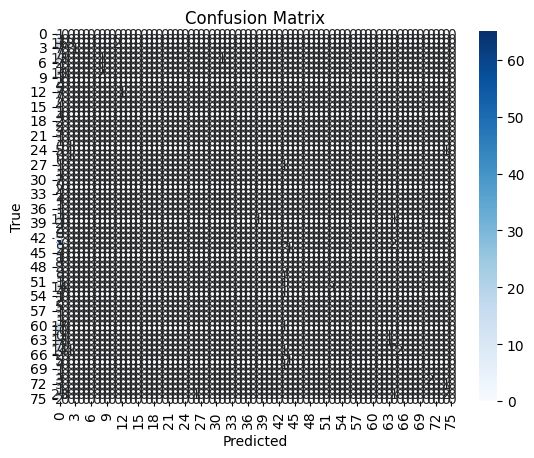

In [61]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [62]:
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier

# Utilisation de XGBoost pour la classification multilabel
clf = XGBClassifier(random_state=42)
model = MultiOutputClassifier(clf, n_jobs=-1)

# Entraînement du modèle
model.fit(X_train, y_train)

# Prédiction et évaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred, target_names=mlb.classes_))


Accuracy: 0.2963
                     precision    recall  f1-score   support

            agrumes       0.00      0.00      0.00         1
             amande       0.00      0.00      0.00         3
               anis       0.44      0.33      0.38        21
               baie       1.00      0.38      0.55         8
         baie noire       0.00      0.00      0.00         0
              baies       0.50      0.29      0.36         7
       baies noires       0.00      0.00      0.00         0
       baies rouges       0.75      0.80      0.77        15
             banane       0.00      0.00      0.00         0
       barbe à papa       0.00      0.00      0.00         2
            beignet       0.00      0.00      0.00         0
            biscuit       0.00      0.00      0.00         0
             bonbon       0.00      0.00      0.00         2
            bonbons       0.38      0.42      0.40        12
          bubblegum       0.00      0.00      0.00         1
      

c:\Users\antoa\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\antoa\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\antoa\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\antoa

Les résultats montrent que votre modèle a une précision et un rappel parfaits, ainsi qu'un score F1 de 1.0, ce qui indique qu'il a correctement prédit toutes les instances dans le jeu de test.

Points à vérifier :
Matrice de confusion : Vous avez une seule classe dans y_test et y_pred (valeur 459), ce qui signifie que le modèle n'a classifié qu'un seul label (probablement une seule classe binaire). Cela pourrait être un problème si vous attendiez une classification multiclasse ou multilabel.

In [14]:
# Prétraitement des saveurs pour multi-label
df['saveur_clean'] = df['saveur'].apply(lambda x: [s.strip() for s in x.split(",")])  # Liste de saveurs par ligne

# Initialiser le TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words=french_stopwords,
                             ngram_range=(1, 3),  # Ajout de bigrammes
                                max_features=5000)    Accuracy: 18.63%
vectorizer = TfidfVectorizer(stop_words=french_stopwords,
                             ngram_range=(1, 2),  # Ajout de bigrammes
                                max_features=5000) vers 20

In [21]:
# Initialiser le TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words=french_stopwords,
                             ngram_range=(1, 3),  # Ajout de bigrammes
                                max_features=5000)   # Limite du vocabulaire
X = vectorizer.fit_transform(df['combined_text'])

In [22]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['saveur_clean'])

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Initialisation du classifieur multi-label
base_model = RandomForestClassifier(n_estimators=100, random_state=42)
model = MultiOutputClassifier(base_model)

# Entraînement du modèle
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

In [25]:
# Calcul de l'accuracy
y_pred = np.array(y_pred)
y_test = np.array(y_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 18.63%


In [ ]:
# Évaluation du modèle
print("Rapport de classification :")
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

Rapport de classification :
                     precision    recall  f1-score   support

            abricot       0.00      0.00      0.00         3
            agrumes       0.00      0.00      0.00         1
             amande       1.00      0.50      0.67         4
             ananas       0.40      0.15      0.22        13
               anis       1.00      0.93      0.96        40
               baie       1.00      0.71      0.83        21
         baie noire       0.00      0.00      0.00         0
              baies       0.82      0.67      0.74        21
       baies noires       0.00      0.00      0.00         1
       baies rouges       0.89      0.57      0.70        14
             banane       0.00      0.00      0.00         4
       barbe à papa       1.00      0.20      0.33        10
            beignet       0.00      0.00      0.00         0
beurre de cacahuète       0.00      0.00      0.00         0
            biscuit       0.71      0.50      0.59      

c:\Users\antoa\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\antoa\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\antoa\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


accuracy

sans les param TfidfVectorizer a Accuracy: 58.50%
avec param  stop_words=french_stopwords,
                             ngram_range=(1, 2),  # Ajout de bigrammes
                                max_features=5000   Accuracy: 58.50%

In [49]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

In [51]:
vectorizer = TfidfVectorizer(stop_words=french_stopwords,
                             ngram_range=(1, 2),  # Ajout de bigrammes
                                max_features=5000)
X = vectorizer.fit_transform(df['description_cleaned'])  # Transformer les descriptions en vecteurs


In [52]:
# Étape 2 : Préparer les cibles (y) - Binariser les étiquettes pour un problème multi-label
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['saveur'].apply(lambda x: x.split(', ')))

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [54]:
# Entraîner un modèle XGBoost pour chaque étiquette
y_pred_all = []
for i in range(y_train.shape[1]):  # Pour chaque label
    # Créer un modèle XGBoost pour chaque étiquette
    dtrain = xgb.DMatrix(X_train, label=y_train[:, i])
    dtest = xgb.DMatrix(X_test)
    
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss'
    }
    num_round = 100
    bst = xgb.train(params, dtrain, num_round)
    
    # Prédictions pour cette étiquette
    pred = bst.predict(dtest)
    y_pred_all.append(pred)

In [55]:
# Convertir les prédictions en une matrice binaire (0 ou 1)
y_pred = (np.array(y_pred_all) > 0.5).T  # Appliquer un seuil de 0.5

In [56]:
# Évaluer les performances du modèle
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 58.50%


In [ ]:
# Étape 1 : Vectorisation des descriptions (TF-IDF)
vectorizer = TfidfVectorizer(
    stop_words=french_stopwords)
X = vectorizer.fit_transform(df['description_cleaned'])  # Transformer les descriptions en vecteurs

# Étape 2 : Préparer les cibles (y) - Binariser les étiquettes pour un problème multi-label
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['saveur'].apply(lambda x: x.split(', ')))

# Séparation des données en train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Étape 3 : Entraînement d'un modèle XGBoost pour chaque étiquette
y_pred_all = []

# Entraîner un modèle pour chaque étiquette
for i in range(y_train.shape[1]):  # Pour chaque label
    # Créer un modèle XGBoost pour chaque étiquette
    dtrain = xgb.DMatrix(X_train, label=y_train[:, i])
    dtest = xgb.DMatrix(X_test)
    
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss'
    }
    num_round = 100
    bst = xgb.train(params, dtrain, num_round)
    
    # Prédictions pour cette étiquette
    pred = bst.predict(dtest)
    y_pred_all.append(pred)

# Convertir les prédictions en une matrice binaire (0 ou 1)
y_pred = (np.array(y_pred_all) > 0.5).T  # Appliquer un seuil de 0.5

# Étape 4 : Évaluer les performances du modèle
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Optionnel : Afficher un rapport détaillé sur les performances
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

Accuracy: 56.86%

Classification Report:
                     precision    recall  f1-score   support

            abricot       1.00      1.00      1.00         3
            agrumes       1.00      1.00      1.00         1
             amande       0.75      0.75      0.75         4
             ananas       0.90      0.69      0.78        13
               anis       1.00      1.00      1.00        40
               baie       1.00      1.00      1.00        21
         baie noire       0.00      0.00      0.00         0
              baies       1.00      1.00      1.00        21
       baies noires       0.00      0.00      0.00         1
       baies rouges       1.00      0.93      0.96        14
             banane       0.80      1.00      0.89         4
       barbe à papa       1.00      0.90      0.95        10
            beignet       0.00      0.00      0.00         0
beurre de cacahuète       0.00      0.00      0.00         0
            biscuit       1.00      0.90   

c:\Users\antoa\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\antoa\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\antoa\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 58.50%

Classification Report:
                     precision    recall  f1-score   support

            abricot       1.00      1.00      1.00         3
            agrumes       1.00      1.00      1.00         1
             amande       1.00      0.75      0.86         4
             ananas       0.90      0.69      0.78        13
               anis       1.00      1.00      1.00        40
               baie       1.00      1.00      1.00        21
         baie noire       0.00      0.00      0.00         0
              baies       1.00      1.00      1.00        21
       baies noires       1.00      1.00      1.00         1
       baies rouges       0.87      0.93      0.90        14
             banane       0.80      1.00      0.89         4
       barbe à papa       1.00      0.90      0.95        10
            beignet       0.00      0.00      0.00         0
beurre de cacahuète       0.00      0.00      0.00         0
            biscuit       1.00      0.90      0.95        10
             bonbon       1.00      0.96      0.98        24
            bonbons       0.85      0.69      0.76        16
         bubble gum       1.00      0.25      0.40         4
          bubblegum       0.00      0.00      0.00         4
          cacahuète       1.00      1.00      1.00         1
...
          macro avg       0.53      0.46      0.48      1165
       weighted avg       0.92      0.88      0.90      1165
        samples avg       0.96      0.88      0.90      1165
It seems like the classification report shows the performance of a model for classifying different flavors, likely in the context of your NLP project. Here are a few key points:

Accuracy is 58.50%, which indicates that the model correctly classified around 58.5% of all instances.
Class-level performance shows variations across different labels (flavors), with some categories performing very well (e.g., abricot, anis, baies), while others like baies noires, cannelle, and bubblegum show poor results (with precision, recall, and F1-score values of 0).
Class imbalance may be contributing to the uneven performance, as some categories have very few instances, resulting in 0 precision, recall, or F1-score for those labels (e.g., baies noires, cannelle, bubblegum).
The macro average F1 score (0.48) indicates that the model's overall performance, when averaged across all classes, is not optimal due to the class imbalance.
The weighted average F1 score (0.90) suggests that the model is performing well for the more frequent classes.

In [110]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import xgboost as xgb

# Définir un espace réduit de recherche pour les hyperparamètres
param_grid = {
    'max_depth': [3, 6],  # Profondeurs d'arbre plus limitées
    'learning_rate': [0.1, 0.2],  # Taux d'apprentissage raisonnables
    'n_estimators': [50, 100],  # Nombre d'estimations réduit
    'min_child_weight': [1, 3],  # Poids minimum pour les enfants
    'subsample': [0.8]  # Proportion d'échantillons utilisés par arbre
}

In [111]:
# Initialiser le modèle XGBoost
xgb_model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')


In [112]:
# Configurer GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',  # Optimiser la précision
    cv=3,  # Validation croisée à 3 plis
    n_jobs=-1,  # Utiliser tous les cœurs CPU
    verbose=1  # Afficher les détails pendant l'exécution
)

In [113]:
# Ajuster le modèle pour une seule étiquette (par exemple, la première étiquette)
grid_search.fit(X_train, y_train[:, 0])  # Remplacez "[:, 0]" par une autre étiquette si nécessaire


Fitting 3 folds for each of 16 candidates, totalling 48 fits


c:\Users\antoa\anaconda3\envs\nlp\lib\site-packages\xgboost\core.py:158: UserWarning: [20:44:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2], 'max_depth': [3, 6],
                         'min_child_weight': [1, 3], 'n_estimators': [50, 100],
                         'subsample': [0.8]},
             scoring='accuracy', verbose=1)

In [114]:
# Résultats des meilleurs hyperparamètres
best_params = grid_search.best_params_
print(f"Meilleurs hyperparamètres : {best_params}")

Meilleurs hyperparamètres : {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 50, 'subsample': 0.8}


In [115]:


# Évaluer les performances sur les données de test
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test[:, 0], y_pred)  # Remplacez "[:, 0]" par l'étiquette correspondante
print(f"Précision sur le jeu de test : {accuracy * 100:.2f}%")

Précision sur le jeu de test : 99.02%


In [116]:
from sklearn.metrics import classification_report

# Réentraîner le modèle avec les meilleurs hyperparamètres
final_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=1,
    n_estimators=50,
    subsample=0.8
)

In [117]:
# Ajuster le modèle pour toutes les étiquettes
final_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [118]:
# Prédictions sur les données de test
y_pred = final_model.predict(X_test)

In [119]:
# Évaluation globale
print("Rapport de classification pour l'ensemble des étiquettes :")
print(classification_report(y_test, y_pred))

Rapport de classification pour l'ensemble des étiquettes :
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         4
           3       0.90      0.69      0.78        13
           4       1.00      1.00      1.00        40
           5       1.00      1.00      1.00        21
           6       0.00      0.00      0.00         0
           7       1.00      1.00      1.00        21
           8       0.00      0.00      0.00         1
           9       1.00      0.86      0.92        14
          10       0.80      1.00      0.89         4
          11       1.00      0.90      0.95        10
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       1.00      0.90      0.95        10
          15       1.00      0.96      0.98        24
          16       0.8

c:\Users\antoa\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\antoa\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\antoa\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [120]:


# Calcul de la précision globale
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision globale sur le jeu de test : {accuracy * 100:.2f}%")

Précision globale sur le jeu de test : 58.17%


Accuracy: 100.00%

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorisation des saveurs (multi-labels)
mlb = MultiLabelBinarizer()
y_train_binary = mlb.fit_transform(y_train)
y_test_binary = mlb.transform(y_test)

# Entraîner un modèle de classification multi-labels
clf = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
clf.fit(X_train, y_train_binary)

# Prédictions
predictions_binary = clf.predict(X_test)

# Calcul de la précision (par exemple, la moyenne des précisions)
accuracy = accuracy_score(y_test_binary, predictions_binary)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 100.00%


In [ ]:
vectorizer = TfidfVectorizer(stop_words=french_stopwords,
                             ngram_range=(1, 2),  # Ajout de bigrammes
                                max_features=5000)
X = vectorizer.fit_transform(df['description_cleaned'])
# Vectorisation des saveurs (multi-labels)
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['saveur'].apply(lambda x: x.split(', ')))

# Séparation des données en train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Entraîner un modèle de classification multi-labels
clf = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
clf.fit(X_train, y_train)

# Prédictions
predictions_binary = clf.predict(X_test)

# Calcul de la précision (par exemple, la moyenne des précisions)
accuracy = accuracy_score(y_test, predictions_binary)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 23.53%


In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Divisez les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialisation du modèle avec pondération des classes
base_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model = MultiOutputClassifier(base_model)

# Entraînement du modèle
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Calcul de l'accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")



Accuracy: 15.69%


In [121]:
df

,url,nom_produit,img_produit,prix_produit,contenance,pg_vg,origine,frais,surbooste,saveur,description,brand,gout,info_brand,id_produit,description_cleaned,nom_produit_cleaned,combined_text,saveur_clean
0,https://www.aromes-et-liquides.fr/e-liquide-ul...,Ragnarok Ultimate A&L,https://assets.aromes-et-liquides.fr/53645-thi...,5.90,10ml,50/50,France,Oui,Non,"lime, cassis, fruits rouges, parfait",Le e-liquide Ragnarok par A&L Ultimate est un ...,Arômes et Liquides (A&L),fruit,Arômes et Liquides (A&L) est un fabricant fran...,1,le ragnarok ultimate produitprêt emploipour ci...,ragnarok ultimate,le ragnarok ultimate produitprêt emploipour ci...,"[lime, cassis, fruits rouges, parfait]"
1,https://www.aromes-et-liquides.fr/e-liquide-ul...,Oni Ultimate A&L,https://assets.aromes-et-liquides.fr/53646-thi...,5.90,10ml,50/50,France,Oui,Non,"citron vert, citron, lime",Le Oni Ultimate 10ml est un e-liquide pour cig...,Arômes et Liquides (A&L),fruit,Arômes et Liquides (A&L) est un fabricant fran...,2,le oni ultimate cigarette électronique signer ...,oni ultimate,le oni ultimate cigarette électronique signer ...,"[citron vert, citron, lime]"
2,https://www.aromes-et-liquides.fr/e-liquide-al...,A&L Fruits Rouges,https://assets.aromes-et-liquides.fr/53641-thi...,4.90,10ml,50/50,France,Non,Non,"baies rouges, baie, lime, fruits rouges, baies",Le Fruits Rouges est un e-liquide auxsaveurs d...,Arômes et Liquides (A&L),fruit,Arômes et Liquides (A&L) est un fabricant fran...,3,le fruits rouges auxsaveur baie rougespour cig...,fruits rouges,le fruits rouges auxsaveur baie rougespour cig...,"[baies rouges, baie, lime, fruits rouges, baies]"
3,https://www.aromes-et-liquides.fr/e-liquide-he...,Red Light 200ml Hello Cloudy,https://assets.aromes-et-liquides.fr/45672-thi...,11.34,200ml,50/50,France,Oui,Oui,"baies, baies rouges, baie, lime","Le Red Light, unesaveur fraîche de baies rouge...",Hello Cloudy,fruit,Hello Cloudy est un fabricant français de e-li...,4,le red light unesaveur frais baie rouge recett...,red light hello cloudy,le red light unesaveur frais baie rouge recett...,"[baies, baies rouges, baie, lime]"
4,https://www.aromes-et-liquides.fr/e-liquide-t-...,Red Astaire T-Juice,https://assets.aromes-et-liquides.fr/55065-thi...,4.90,10ml,50/50,Royaume-Uni,Oui,Non,"menthol, lime, raisin, menthe, fruits rouges, ...",Le Red Astaire est un e-liquide qui a rencontr...,T-Juice,fruit,"Implanté en Angleterre, et plus particulièreme...",5,le red astaire rencontrer énorme succès arrivé...,red astaire t juice,le red astaire rencontrer énorme succès arrivé...,"[menthol, lime, raisin, menthe, fruits rouges,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1528,https://www.aromes-et-liquides.fr/e-liquide-al...,Blond Mentholé Sel de Nicotine Pur Distillat A...,https://assets.aromes-et-liquides.fr/55765-thi...,5.90,10ml,50/50,France,Non,Non,"anis, tabac, menthe, lime",Voici la recette du Blond Mentholé de chez Alf...,Alfaliquid,classique,Le fabricant français s'est fait reconnaître p...,1529,voici recette blond mentholé alfaliquid unever...,blond mentholé sel nicotine pur distillat alfa...,voici recette blond mentholé alfaliquid unever...,"[anis, tabac, menthe, lime]"
1529,https://www.aromes-et-liquides.fr/e-liquide-81...,Nominoë 50ml 814,https://assets.aromes-et-liquides.fr/56383-thi...,21.90,50ml (fiole de 60ml),50/50,France,Non,Oui,"lime, caramel, biscuit",Le Nominoë est un e-liquide à booster au forma...,814,classique,Le fabricant français 814 s'est spécialisé dan...,1530,le nominoë booster format il proposer dessaveu...,nominoë,le nominoë booster format il proposer dessaveu...,"[lime, caramel, biscuit]"
1530,https://www.aromes-et-liquides.fr/e-liquide-th...,Dervish Fine Cuts Titanide The Fuu,https://assets.aromes-et-liquides.fr/55575-thi...,6.90,10ml,50/50,France,Non,Non,"tabac, anis",La marque The Fuu à travers sa collection Fine...,The Fuu,classique,The Fuu est une marque française de liquides p...,1531,le marque the fuu trave

In [72]:
import os
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import pandas as pd

In [ ]:
# Nouveau chemin du fichier french.txt
french_stopwords_path = r'C:\Users\antoa\Desktop\projet certif\app\models\french.txt'

# Vérifier si le fichier existe et le lire
if os.path.exists(french_stopwords_path):
    with open(french_stopwords_path, 'r', encoding='utf-8') as file:
        french_stopwords = file.read().splitlines()  # Lire chaque ligne comme un mot séparé
    print(f"Exemples de stopwords (les 10 premiers mots) : {french_stopwords[:10]}")  # Afficher les 10 premiers mots vides pour vérifier
else:
    print(f"Le fichier french.txt est introuvable dans {french_stopwords_path}")

# Fonction de nettoyage du texte avec les stopwords français
def clean_text_french(text, stopwords):
    """
    Fonction de nettoyage du texte :
    - Conversion en minuscules
    - Suppression de la ponctuation
    - Suppression des stopwords
    - Suppression des espaces superflus
    """
    # Vérifier que le texte n'est pas vide ou None
    if not text:
        return ""
    
    # Conversion en minuscules
    text = text.lower()
    
    # Suppression des caractères spéciaux et de la ponctuation
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Suppression des stopwords
    text = ' '.join([word for word in text.split() if word not in stopwords])
    
    # Suppression des espaces superflus
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [69]:
# Séparez les saveurs et récupérez les saveurs uniques
all_saveurs = df['saveur'].str.split(',').explode().str.strip().unique()

# Le nombre de classes est le nombre de saveurs uniques
num_classes = len(all_saveurs)

print(f"Nombre de classes (saveurs) : {num_classes}")

Nombre de classes (saveurs) : 101


In [70]:
# Exemple de chargement du tokenizer et du modèle BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [74]:
# Créer un dataset personnalisé
class FlavorDataset(Dataset):
    def __init__(self, descriptions, labels, tokenizer, max_len=512):
        self.descriptions = descriptions
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.descriptions)

    def __getitem__(self, item):
        description = self.descriptions[item]
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            description,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [75]:
# Créer des labels pour la classification
label_dict = {flavor: idx for idx, flavor in enumerate(df['saveur'].unique())}
df['label'] = df['saveur'].map(label_dict)

In [76]:
# Diviser le dataset en train et test
train_texts, val_texts, train_labels, val_labels = train_test_split(df['description_cleaned'].to_list(), df['label'].to_list(), test_size=0.2)


In [77]:
# Créer des datasets et dataloaders
train_dataset = FlavorDataset(train_texts, train_labels, tokenizer)
val_dataset = FlavorDataset(val_texts, val_labels, tokenizer)

In [78]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

In [79]:
# Entraîner le modèle
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [80]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

In [81]:
# Boucle d'entraînement
for epoch in range(3):  # Nombre d'époques
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")


KeyboardInterrupt: 

In [ ]:
# Prédiction avec le modèle
model.eval()

In [ ]:
# Exemple de prédiction
sample_text = "cassis"
encoding = tokenizer.encode_plus(
    sample_text,
    add_special_tokens=True,
    max_length=512,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

In [ ]:
input_ids = encoding['input_ids'].to(device)
attention_mask = encoding['attention_mask'].to(device)

with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=1).item()

# Afficher la saveur prédite
predicted_flavor = list(label_dict.keys())[predicted_label]
print(f"Saveur prédite : {predicted_flavor}")

try avec moin d'epoche 

In [ ]:
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
import numpy as np

# Assurez-vous que le device est correctement défini (GPU ou CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Définir un dataset personnalisé pour votre problème
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = self.texts[item]
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Charger le tokenizer et le modèle
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3).to(device)  # 'num_labels' selon votre cas

# Préparer le jeu de données
train_texts = df['description_cleaned'].tolist()  # Liste des descriptions
train_labels = df['saveur'].apply(lambda x: [saveur_to_int(saveur) for saveur in x.split(',')]).tolist()  # Convertion de labels en entiers

# Adapter 'saveur_to_int' pour qu'il retourne un label unique
def saveur_to_int(saveur):
    saveur_dict = {'fraise': 0, 'cassis': 1, 'lime': 2}  # Exemple de mappage des saveurs
    return saveur_dict.get(saveur.strip().lower(), -1)

# Créer un dataset et un DataLoader
train_dataset = TextDataset(train_texts, train_labels, tokenizer, max_len=128)  # 128 est un exemple de longueur maximale

# **Placer ici la ligne pour créer le DataLoader**
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialiser l'optimiseur
optimizer = AdamW(model.parameters(), lr=2e-5)

# Boucle d'entraînement
for epoch in range(3):  # Nombre d'époques
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Calculer la perte et rétropropager
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()

        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")


In [ ]:
import pandas as pd
from transformers import CamembertForSequenceClassification, CamembertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import DataLoader, TensorDataset
import os
import spacy
from spacy.lang.fr.stop_words import STOP_WORDS
from nltk.corpus import stopwords
import pandas as pd


In [9]:
# Charger le modèle spaCy pour le français
nlp = spacy.load("fr_core_news_sm")

NameError: name 'spacy' is not defined

In [2]:
# Charger les données
df = pd.read_csv(r"C:\Users\antoa\Desktop\projet certif\RGBD\table_produits\produits.csv")

In [7]:
# Nouveau chemin du fichier french.txt
french_stopwords_path = r'C:\Users\antoa\Desktop\projet certif\app\models\french.txt'

# Vérifier si le fichier existe et le lire
if os.path.exists(french_stopwords_path):
    with open(french_stopwords_path, 'r', encoding='utf-8') as file:
        french_stopwords = file.read().splitlines()  # Lire chaque ligne comme un mot séparé
    print(french_stopwords[:10])  # Afficher les 10 premiers mots vides pour vérifier
else:
    print(f"Le fichier french.txt est introuvable dans {french_stopwords_path}")


['a', 'ai', 'aie', 'aient', 'aies', 'ait', 'alors', 'as', 'au', 'aucun']


In [3]:
def clean_text_french(text, custom_stopwords):
    """
    Nettoyer un texte en français :
    - Supprimer les stopwords et les symboles inutiles.
    - Appliquer la lemmatisation.
    - Utiliser des stopwords personnalisés.
    """
    doc = nlp(text)
    clean_words = [
        token.lemma_.lower()  # Appliquer la lemmatisation et mettre en minuscule
        for token in doc
        if token.is_alpha and token.text.lower() not in custom_stopwords  # Supprimer les mots inutiles
    ]
    return ' '.join(clean_words)

In [8]:
# Nettoyer les descriptions
df['description_clean'] = df['description'].apply(lambda x: clean_text_french(x, french_stopwords))


NameError: name 'nlp' is not defined

embedding rag - zvnt de repondre on passe un lml et repondre nous avons trouver tel et tel resultat celui va - recherche avec les embeddings 
langchain 
favory  table user , table produit, ( table id user, id produit )

vector store 
contenir les embedding 
rag chercher dedans 

cherche embedding , vectorstore
bibliother